In [1]:
import numpy as np
import math
from datetime import date
import yfinance as yf
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import newaxis
import time #helper libraries

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [3]:
df = pd.read_csv('OPC_Bag_DailySales.csv')
columns = ['Date','Quantity In Quintal']
df = pd.DataFrame(df.values,columns=columns)
dataset = df['Quantity In Quintal'].values
dateset = dataset.astype('float32')
dateset = dateset.reshape(len(dataset), 1)
dataset= dataset.reshape(-1, 1)
dataset.shape

(394, 1)

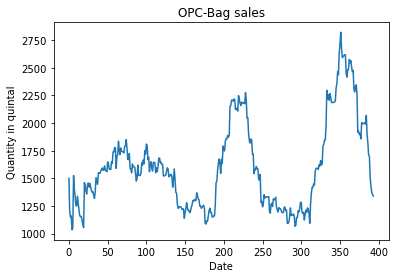

In [4]:
plt.plot(dateset)
plt.xlabel('Date')
plt.ylabel('Quantity in quintal')
plt.title('OPC-Bag sales')
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

315 79


In [6]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(100, input_dim=1,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM( 100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
# model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='mean_squared_error', optimizer='adam')
print ('compilation time : ', time.time() - start)

model.fit(trainX, trainY, epochs=22, batch_size=1, verbose=2)

compilation time :  0.015970468521118164
Epoch 1/22
313/313 - 4s - loss: 0.0121 - 4s/epoch - 13ms/step
Epoch 2/22
313/313 - 1s - loss: 0.0026 - 954ms/epoch - 3ms/step
Epoch 3/22
313/313 - 1s - loss: 0.0025 - 879ms/epoch - 3ms/step
Epoch 4/22
313/313 - 1s - loss: 0.0027 - 682ms/epoch - 2ms/step
Epoch 5/22
313/313 - 1s - loss: 0.0025 - 715ms/epoch - 2ms/step
Epoch 6/22
313/313 - 1s - loss: 0.0023 - 764ms/epoch - 2ms/step
Epoch 7/22
313/313 - 1s - loss: 0.0026 - 717ms/epoch - 2ms/step
Epoch 8/22
313/313 - 1s - loss: 0.0026 - 685ms/epoch - 2ms/step
Epoch 9/22
313/313 - 1s - loss: 0.0022 - 693ms/epoch - 2ms/step
Epoch 10/22
313/313 - 1s - loss: 0.0024 - 688ms/epoch - 2ms/step
Epoch 11/22
313/313 - 1s - loss: 0.0021 - 699ms/epoch - 2ms/step
Epoch 12/22
313/313 - 1s - loss: 0.0023 - 687ms/epoch - 2ms/step
Epoch 13/22
313/313 - 1s - loss: 0.0025 - 700ms/epoch - 2ms/step
Epoch 14/22
313/313 - 1s - loss: 0.0024 - 699ms/epoch - 2ms/step
Epoch 15/22
313/313 - 1s - loss: 0.0021 - 672ms/epoch - 2ms/

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         40800     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trai

[[0.1911453]]
[[0.20380086]]
[[0.192499]]
[[0.15963924]]
[[0.09019899]]
[[1375.1042]
 [1397.7327]
 [1377.5248]
 [1318.7709]
 [1194.6106]]


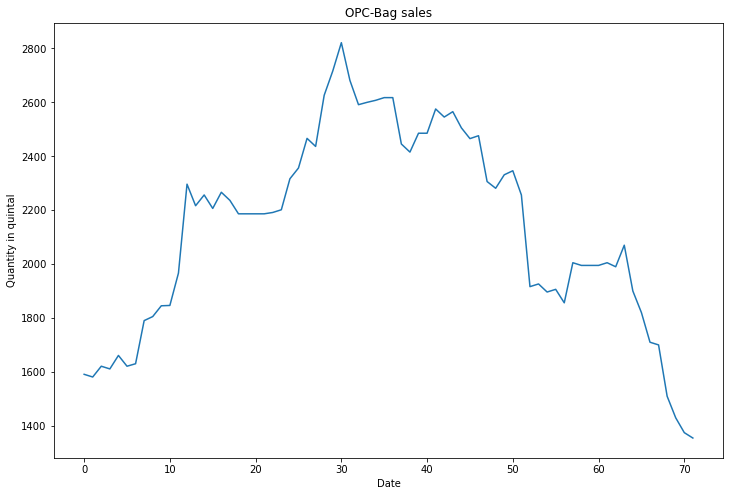

In [9]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.xlabel('Date')
    plt.ylabel('Quantity in quintal')
    plt.title('OPC-Bag sales')
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))

plt.rcParams["figure.figsize"] = (12,8)
plot_results_multiple(predictions, testY, predict_length)


In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 89.39 RMSE
Test Score: 142.44 RMSE


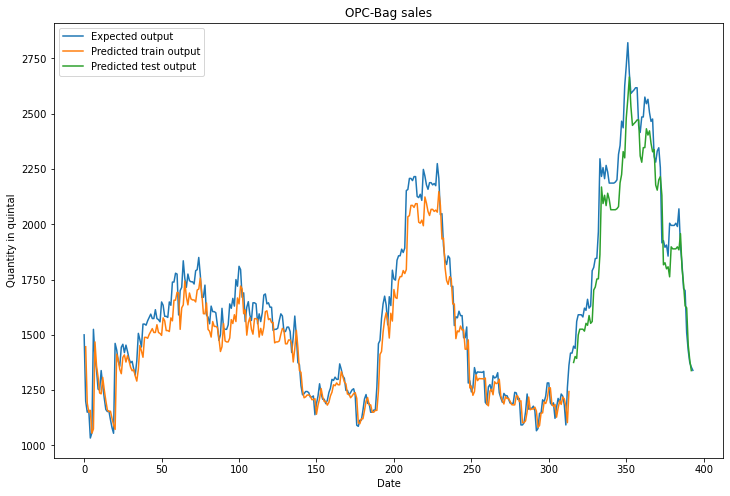

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),label='Expected output')
plt.plot(trainPredictPlot,label='Predicted train output')
plt.plot(testPredictPlot,label='Predicted test output')
plt.xlabel('Date')
plt.ylabel('Quantity in quintal')
plt.title('OPC-Bag sales')
plt.legend(loc="upper left")
plt.show()

In [12]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))

Last Day Value: 1338.2349853515625
Next Day Value: 1222.099609375


<ipython-input-12-a3575500764a>:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
<ipython-input-12-a3575500764a>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))


In [13]:
# calculate manually
d = testY[0] -testPredict[:,0]
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)


print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)


Results by manual calculation:
MAE: 120.58635031960226
MSE: 20287.7823547784
RMSE: 142.4351865052256
